In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import scipy.stats as st
from scipy.optimize import minimize
import math
from multiprocessing import Pool
import emcee
import seaborn as sns
import pandas as pd # Import pandas to handle the data set

def Omega_k(Omega_m0, Omega_l0, Omega_r0):
    Omega_k0 = 1 - Omega_m0 - Omega_l0 - Omega_r0
    return Omega_k0

def E(x, Omega_m0,  Omega_l0,  Omega_r0):
    return np.sqrt(Omega_m0*(1+x)**3  + Omega_k(Omega_m0, Omega_l0, Omega_r0)*(1+x)**2 + Omega_l0)

def IntFunct(x, Omega_m0, Omega_l0, Omega_r0):
    return E(x, Omega_m0, Omega_l0, Omega_r0)**(-1)

def integral(z, Omega_m0, Omega_l0, Omega_r0):
    #return integrate.quad(IntFunct,0, z, args=(Omega_m0, Omega_l0, Omega_r0),epsabs=1.49e-4, epsrel=1.49e-03,full_output = 1)[0]
    return integrate.quad(IntFunct,0, z, args=(Omega_m0, Omega_l0, Omega_r0),epsabs=1.49e-4, epsrel=1.49e-03,full_output = 1)[0]

def distancia_luminosidad(z, h0, Omega_m0,  Omega_l0,  Omega_r0):
    
    c = 3 * 10**5 # km / s
    intl = integral(z, Omega_m0, Omega_l0, Omega_r0)
    
    if Omega_k(Omega_m0, Omega_l0, Omega_r0) < 0: # Abierto
        prefactor = c * (1 + z)/(math.sqrt(abs(Omega_k(Omega_m0, Omega_l0, Omega_r0))) * h0)
        d_L = prefactor * np.sin(math.sqrt(abs(Omega_k(Omega_m0, Omega_l0, Omega_r0))) * intl)
    elif Omega_k(Omega_m0, Omega_l0, Omega_r0) == 0: 
        d_L = c * (1 + z) * intl / h0
    else: # Cerrado
        prefactor = c * (1 + z)/(math.sqrt(abs(Omega_k(Omega_m0, Omega_l0, Omega_r0))) * h0)
        d_L = prefactor * np.sinh(math.sqrt(abs(Omega_k(Omega_m0, Omega_l0, Omega_r0))) * intl)
        
    return d_L

def mod_dist(z, h0, Omega_m0,  Omega_l0,  Omega_r0):
    
    c = 3 * 10**5 # km / s
    intl = integral(z, Omega_m0, Omega_l0, Omega_r0)
    
    if Omega_k(Omega_m0, Omega_l0, Omega_r0) < 0: # Abierto
        prefactor = c * (1 + z)/(math.sqrt(abs(Omega_k(Omega_m0, Omega_l0, Omega_r0))) * h0)
        d_L = prefactor * np.sin(math.sqrt(abs(Omega_k(Omega_m0, Omega_l0, Omega_r0))) * intl)
    elif Omega_k(Omega_m0, Omega_l0, Omega_r0) == 0: 
        d_L = c * (1 + z) * intl / h0
    else: # Cerrado
        prefactor = c * (1 + z)/(math.sqrt(abs(Omega_k(Omega_m0, Omega_l0, Omega_r0))) * h0)
        d_L = prefactor * np.sinh(math.sqrt(abs(Omega_k(Omega_m0, Omega_l0, Omega_r0))) * intl)
        
    return -5+5*np.log10(d_L*10**6)

mod_dist_vec = np.vectorize(mod_dist)

<ErrorbarContainer object of 3 artists>

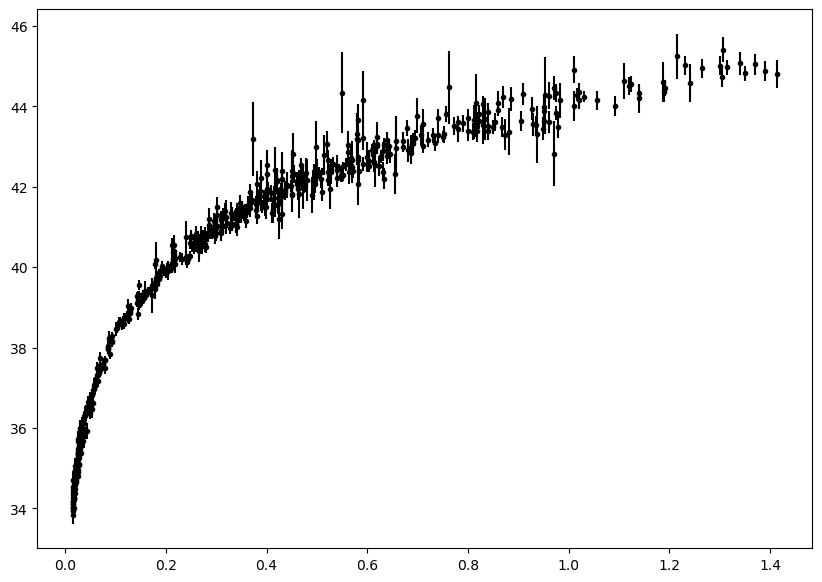

In [24]:
z_vec_union = np.genfromtxt("datos_union.csv", delimiter = ";", usecols = 0)
mu_data_union = np.genfromtxt("datos_union.csv", delimiter = ";", usecols = 1)
mu_err_union = np.genfromtxt("datos_union.csv", delimiter = ";", usecols = 2)



z_datos_ordenado, mu_datos_ordenado, mu_error_datos_ordenado = zip(*sorted(zip(z_vec_union, mu_data_union, mu_err_union)))
#print(z_datos_ordenado)
plt.figure(figsize=(10,7))
plt.errorbar(z_datos_ordenado, mu_datos_ordenado, yerr=mu_error_datos_ordenado, fmt = ".k")

<ErrorbarContainer object of 3 artists>

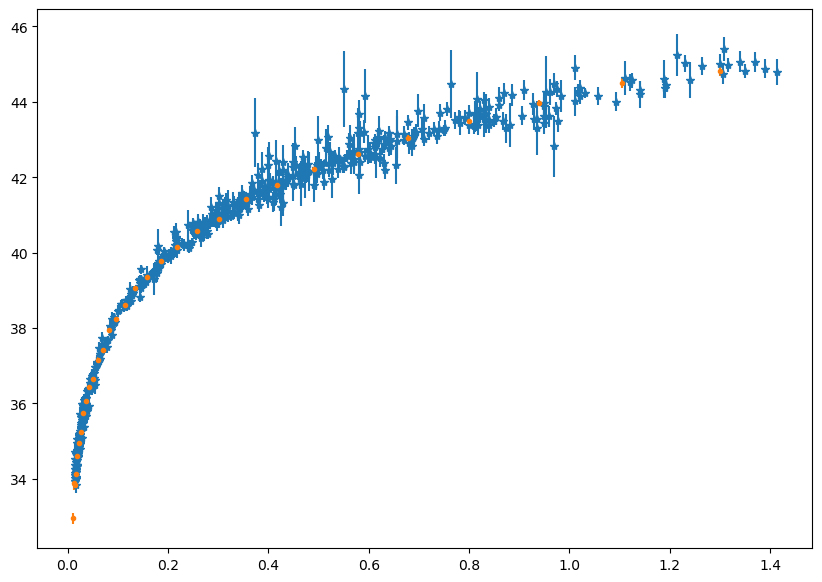

In [25]:
JLA_z_mu= np.genfromtxt("jla_mub_0.csv", delimiter = ',')
cov_matrix = np.genfromtxt("jla_mub_covmatrix.csv", delimiter = ',').reshape(31,31)

z_vec_jla = JLA_z_mu[:, 0] 
mu_data_jla = JLA_z_mu[:, 1]
mu_err_jla = np.sqrt(np.diagonal(cov_matrix))


plt.figure(figsize=(10,7))
plt.errorbar(z_vec_union, mu_data_union, mu_err_union, fmt = "*")
plt.errorbar(z_vec_jla, mu_data_jla, mu_err_jla, fmt = ".")


In [26]:
Omega_r0 = 0.0

def log_likelihood_UNION(theta, z_vec, distancia, yerr):
    h0, Omega_m0, Omega_l0 = theta # Parámetros a minimizar
    Omega_l0 = 1 - Omega_m0
    Omega_r0 = 0
    model = mod_dist_vec(z_vec, h0, Omega_m0, Omega_l0, Omega_r0)
    sigma2 = np.array(yerr)**2
    return -0.5 * np.sum((distancia - model) ** 2 / sigma2)

cov_inv = np.linalg.inv(cov_matrix) # Calculating the inverse matrix
cov_eigvals = np.linalg.eig(cov_matrix)[1] # Calculates the eigenvalues of the covariance matrix

def log_probability_JLA(theta, z_vec, mu_data, cov_matrix, cov_inv, cov_eigvals):
    """Compute the Gaussian log-likelihood for a given distance modulus data, distance modulus theorical and covariance."""
    h0, Omega_m0, Omega_l0 = theta 
    Omega_r0 = 0.0
    cov_len = len(cov_matrix)
    mu_model_array = mod_dist_vec(z_vec, h0, Omega_m0, Omega_l0, Omega_r0)
    return -0.5 * (np.matmul((mu_model_array - mu_data) , np.matmul(cov_inv , (mu_model_array - mu_data)))) - .5 * (np.sum(np.log(np.absolute(cov_eigvals[1]))) + cov_len * np.log(2*np.pi))

def log_likelihood(theta, z_vec_union, mu_data_union, mu_err_union, z_vec_jla, mu_data_jla, cov_matrix, cov_inv, cov_eigvals):
    return log_likelihood_UNION(theta, z_vec_union, mu_data_union, mu_err_union) + log_probability_JLA(theta, z_vec_jla, mu_data_jla, cov_matrix, cov_inv, cov_eigvals)
    #return log_probability_JLA(theta, z_vec_jla, mu_data_jla, cov_matrix, cov_inv, cov_eigvals)

def log_prior(theta):
    h0, Omega_m0, Omega_l0 = theta # Parámetros a minimizar
    if 50< h0 < 100 and 0 < Omega_m0 < 1 and 0 < Omega_l0 < 1: # and and 0.0 < Omega_m0+Omega_l0+Omega_k(Omega_m0, Omega_l0, Omega_r0) <= 1.0
        return 0.0
    return -np.inf

def condition(theta, z):
    H, Omega_m0, Omega_l0 = theta
    
    z_max = np.max(z)
    result = Omega_m0*(1+z_max)**3  + Omega_k(Omega_m0, Omega_l0, Omega_r0)*(1+z_max)**2 + Omega_l0
    if result < 0:
        return -np.inf
    return result


def log_probability(theta, z_vec_union, mu_data_union, mu_err_union, z_vec_jla, mu_data_jla, cov_matrix, cov_inv, cov_eigvals):
    if not np.isfinite(log_prior(theta)):
        lp = -np.inf
        return lp
    if not np.isfinite(condition(theta, z_vec_union)):
        lp = -np.inf
        return lp
    if not np.isfinite(condition(theta, z_vec_jla)):
        lp = -np.inf
        return lp
    lp = 0.0
    Likelihood = log_likelihood(theta, z_vec_union, mu_data_union, mu_err_union, z_vec_jla, mu_data_jla, cov_matrix, cov_inv, cov_eigvals) +lp
    return Likelihood # Si el valor de lp es finito, contruimos la funcion probabilidad

In [27]:
theta = [67, 0.33, 0.69]

log_likelihood(theta, z_vec_union, mu_data_union, mu_err_union, z_vec_jla, mu_data_jla, cov_matrix, cov_inv, cov_eigvals)


-327.51284155166906

In [28]:
max_n = 10000

# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# This will be useful to testing convergence
old_tau = np.inf

h0_random = np.random.uniform(50, 100, 100)
omega_m_random = np.random.uniform(0, 1, 100)
omega_lambda_random = np.random.uniform(0, 1, 100)
pos = []
pos = np.column_stack((h0_random, omega_lambda_random, omega_m_random)) # Escribe los 3 vectores como columnas
nwalkers, ndim = pos.shape  # nwalker y ndim toma el valor del número de filas y el número de columnas del vector "pos", respectivamente.



with Pool(processes=6) as pool:
    sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(z_vec_union, mu_data_union, mu_err_union, z_vec_jla, mu_data_jla, cov_matrix, cov_inv, cov_eigvals))
    # Now we'll sample for up to max_n steps
    for sample in sampler.sample(pos, iterations=max_n, progress=True):
        # Only check convergence every 100 steps
        if sampler.iteration % 100:
            continue

        # Compute the autocorrelation time so far
        # Using tol=0 means that we'll always get an estimate even
        # if it isn't trustworthy
        tau = sampler.get_autocorr_time(tol=0)
        autocorr[index] = np.mean(tau)
        index += 1

        # Check convergence
        # np.all() es una función de NumPy que devuelve True si todos los elementos en 
            # una matriz o expresión son evaluados como verdaderos, y False en caso contrario.
        # If the chain is longer than 100 times the estimated autocorrelation time and if 
            # this estimate changed by less than 1%, we’ll consider things converged.
        converged = np.all(sampler.iteration > 100 * tau)  
        converged &= np.all(np.abs(old_tau - tau) / tau < 0.01) 
        if converged:
            break
        old_tau = tau
        n = 100 * np.arange(1, index + 1)
        y = autocorr[:index]  
        plt.plot(n, n / 100.0, "--k", label = "Línea $\tau / 100$")
            # Pintamos la recta x = y / 100 porque una condición de convergencia es que 
            # la cadena sea 100 veces más larga que tau. De esta manera podremos
            # comprobarlo de manera más visual
        plt.plot(n, y, label = "$\tau$ calculada")
        plt.xlim(0, n.max())
        #plt.ylim(0, y.max() + 0.1 * (y.max() - y.min()))
        plt.xlabel("Número de elementos de la cadena")
        plt.ylabel(r"$\hat{\tau}$ medio")
        file_name_fig = 'autocorrelation.pdf'
        plt.savefig(file_name_fig)
        plt.close()

        
n = 100 * np.arange(1, index + 1)
y = autocorr[:index]  
plt.plot(n, n / 100.0, "--k", label = r"Línea $\hat{\tau} / 100$")
     # Pintamos la recta x = y / 100 porque una condición de convergencia es que 
     # la cadena sea 100 veces más larga que tau. De esta manera podremos
     # comprobarlo de manera más visual
plt.plot(n, y, label = r"$\hat{\tau}$ calculado")
plt.xlim(0, n.max())
#plt.ylim(0, y.max() + 0.1 * (y.max() - y.min()))
plt.xlabel("Número de elementos de la cadena")
plt.ylabel(r"$\hat{\tau}$ medio")
plt.legend(loc = "lower right")
file_name_fig = 'autocorrelation.pdf'
plt.savefig(file_name_fig)
plt.close()
plt.show()

 34%|███▍      | 3406/10000 [6:25:05<46:13:14, 25.23s/it]

emcee: Exception while calling your likelihood function:
  params: [70.29893833  0.2806894   0.58868523]
  args: 

Traceback (most recent call last):
  File "C:\Users\jaime\anaconda3\lib\site-packages\emcee\ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "C:\Users\jaime\AppData\Local\Temp\ipykernel_17636\4094535490.py", line 53, in log_probability
    Likelihood = log_likelihood(theta, z_vec_union, mu_data_union, mu_err_union, z_vec_jla, mu_data_jla, cov_matrix, cov_inv, cov_eigvals) +lp
  File "C:\Users\jaime\AppData\Local\Temp\ipykernel_17636\4094535490.py", line 23, in log_likelihood
    return log_likelihood_UNION(theta, z_vec_union, mu_data_union, mu_err_union) + log_probability_JLA(theta, z_vec_jla, mu_data_jla, cov_matrix, cov_inv, cov_eigvals)
  File "C:\Users\jaime\AppData\Local\Temp\ipykernel_17636\4094535490.py", line 7, in log_likelihood_UNION
    model = mod_dist_vec(z_vec, h0, Omega_m0, Omega_l0, Omega_r0)
  File "C:\Users\jaime\anaconda3\lib\site-packages\numpy\lib\function_base.py", line 2328, in __call__
    return self._vectorize_call(fun

(array([0.028488  , 0.050043  , 0.052926  , 0.070086  , 0.062668  ,
       0.087589  , 0.078577  , 0.017227  , 0.042233  , 0.045295  ,
       0.03648   , 0.019599  , 0.100915  , 0.027342  , 0.074605  ,
       0.026489  , 0.049922  , 0.030604  , 0.01634564, 0.0154363 ,
       0.030529  , 0.024525  , 0.023953  , 0.026038  , 0.048948  ,
       0.024314  , 0.015166  , 0.03572   , 0.048818  , 0.02198001,
       0.1244    , 0.036     , 0.016321  , 0.01673   , 0.0275    ,
       0.021793  , 0.01645   , 0.023208  , 0.036457  , 0.019264  ,
       0.017605  , 0.031528  , 0.023536  , 0.016743  , 0.05371   ,
       0.016991  , 0.027865  , 0.017173  , 0.029955  , 0.016559  ,
       0.015     , 0.0544    , 0.1561    , 0.0393    , 0.1241    ,
       0.1441    , 0.1299    , 0.0784    , 0.0583    , 0.0309    ,
       0.0406    , 0.0152    , 0.0224    , 0.016     , 0.0362    ,
       0.0173    , 0.0312    , 0.0221    , 0.016     , 0.0249    ,
       0.0303    , 0.0283    , 0.0152    , 0.0345    , 0.036 

KeyboardInterrupt: 

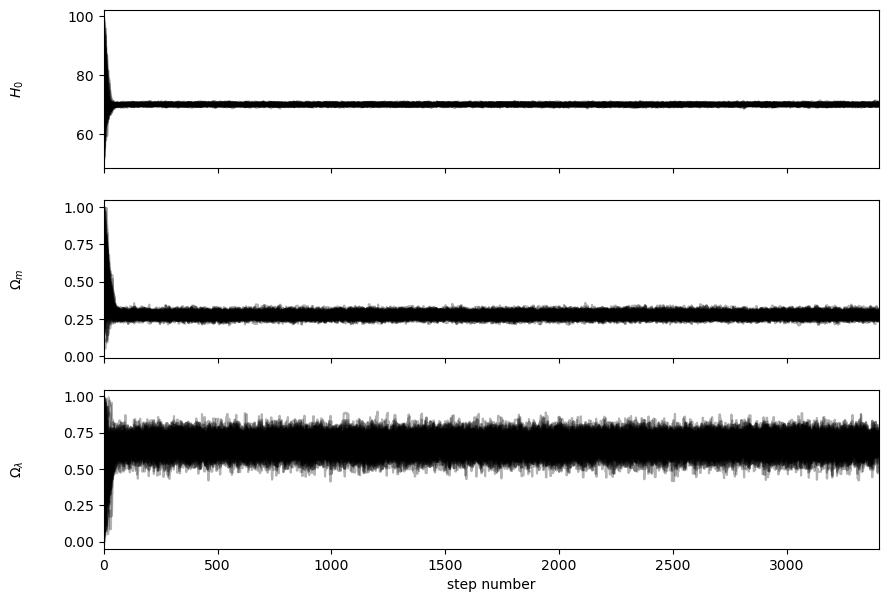

In [29]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["$H_0$", "$\Omega_m$", "$\Omega_\lambda$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [30]:
tau = sampler.get_autocorr_time()  # autocorrelation
print(tau)
print("-----")
burnin = int(2 * np.max(tau))  # burn in phase
thin = int(0.5 * np.min(tau))  #
flat_samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)
print(flat_samples)
np.savetxt('flat_samples_union+jla_noflat.csv', flat_samples, delimiter = ',')

[23.81408464 31.79801189 35.59359259]
-----
[[70.08150699  0.27628555  0.56143817]
 [70.27542691  0.26747321  0.59744491]
 [69.55780278  0.30200165  0.65021311]
 ...
 [70.29009338  0.27954872  0.6456916 ]
 [70.17932187  0.25699485  0.72123082]
 [70.51544932  0.26173092  0.62998874]]


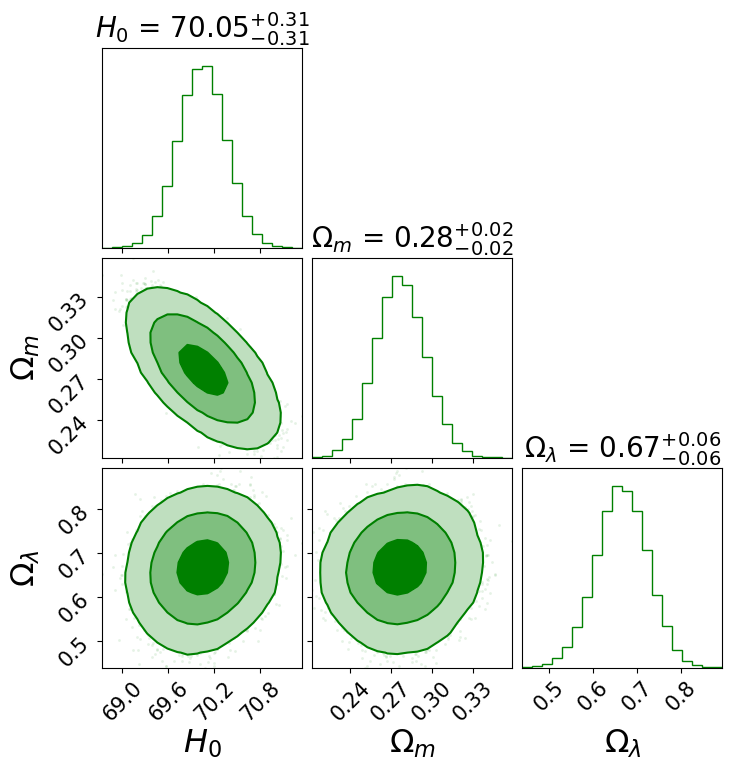

In [2]:
import corner
# Parámetros del modelo

labels = ["$H_0$", "$\Omega_m$", "$\Omega_\lambda$"]
flat_samples = np.genfromtxt('flat_samples_union+jla_noflat.csv', delimiter = ",")

fig = corner.corner(flat_samples, labels=labels,fill_contours=True,bins=20, color='green', show_titles=True,smooth=1.0, 
                        label_kwargs={"fontsize": 23},title_kwargs={"fontsize": 20}, tick_kwargs={"fontsize": 30},
                        levels=(1-np.exp(-0.5),1-np.exp(-2.0),1-np.exp(-4.5)))

fontsize = 15
for ax in fig.get_axes():
    plt.setp(ax.get_xticklabels(), fontsize=fontsize)
    plt.setp(ax.get_yticklabels(), fontsize=fontsize)
fig.savefig('corner_unio+jla_noflat.pdf')

In [3]:
from IPython.display import display, Math

results = []
for i in range(3):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    print(mcmc)
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    append = [mcmc[1], q[0], q[1]]
    results.append(append)
    display(Math(txt))
np.savetxt('Resultados_union+jla_noflat.csv', results, delimiter=',')

[69.73951576 70.04894283 70.35617297]


<IPython.core.display.Math object>

[0.25903546 0.27682301 0.295264  ]


<IPython.core.display.Math object>

[0.60845382 0.66675663 0.7251977 ]


<IPython.core.display.Math object>